In [1]:

import numpy as np
from astropy.io import fits
from scipy.io.idl import readsav
import scipy.signal as signal
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from ugdopplerfast import ugdopplerfast
import glob



In [2]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth


In [86]:

# Read in the cal data 
tcal_path  = './tcal/'
tcal_hi_w  = 'median_20190115.Tcal-results.HI_w.high.sav'

s          = readsav(tcal_path + tcal_hi_w)
freqcal    = s.high_w[0]['freq']
m15_tc     = s.high_w[0]['M15_TC']
m15_tc_polave =  np.average(m15_tc,axis=0)  # average for polarization

Tcal          = m15_tc_polave


In [11]:
target_ID = 'NGC6946/'
obs_date = '20210312/'
path_to_data = '/home/cheng/Data6T/FAST-NGC6946/PT2020_0027/'
filenames=glob.glob(path_to_data+target_ID+obs_date+'/*M15_W*.fits')
filenames.sort()
path_to_data+target_ID+obs_date

'/home/cheng/Data6T/FAST-NGC6946/PT2020_0027/NGC6946/20210312/'

In [12]:
filenames

['/home/cheng/Data6T/FAST-NGC6946/PT2020_0027/NGC6946/20210312/NGC6946_3_onoff-M15_W_0001.fits',
 '/home/cheng/Data6T/FAST-NGC6946/PT2020_0027/NGC6946/20210312/NGC6946_3_onoff-M15_W_0002.fits',
 '/home/cheng/Data6T/FAST-NGC6946/PT2020_0027/NGC6946/20210312/NGC6946_3_onoff-M15_W_0003.fits',
 '/home/cheng/Data6T/FAST-NGC6946/PT2020_0027/NGC6946/20210312/NGC6946_3_onoff-M15_W_0004.fits']

In [13]:
hdu = fits.open(filenames[0])

freqbegin = hdu[1].data.field('freq')[0]                 # freq of frist channel
chanbw    = hdu[1].data.field('CHAN_BW')[0]              # Channel width
nchan     = hdu[1].data.field('NCHAN')[0]                # channel number
freq      =  freqbegin + (np.arange(nchan)+0)*chanbw      # Freq of all channels
freq

data = hdu[1].data.field('DATA')                    # Data
mjd  = hdu[1].data.field('UTOBS')                   # mjd
start_mjd = mjd[0]

for ind_file in range(len(filenames)-1):
    hdu = fits.open(filenames[ind_file+1])
    # Merging the data 
    data  = np.concatenate([data, hdu[1].data.field('DATA')],axis=0)
    mjd   = np.concatenate([mjd,hdu[1].data.field('UTOBS')],axis=0)



In [14]:
data.shape

(6497, 65536, 4)

In [15]:
freq

array([1000.00357628, 1000.01120567, 1000.01883507, ..., 1499.9806881 ,
       1499.98831749, 1499.99594688])

In [17]:
min_to_MJD    = 1./60./24.  # mjd value for 1 minute
start_mjd = mjd[0]
on_time = 10 #  min
int_time = 1. #  min
# if On - off distance is larger then 30 arcmin. It takes 1min to change the pointing from ON to OFF the target.
# if On - off distance is lower then 30 arcmin. It takes 0.5min to change the pointing from ON to OFF the target.

cycles_mjd = [\
start_mjd +  0 * on_time * min_to_MJD + 0 * int_time * min_to_MJD , start_mjd +  1 * on_time * min_to_MJD + 0 * int_time * min_to_MJD , # 1st on the target 
start_mjd +  1 * on_time * min_to_MJD + 1 * int_time * min_to_MJD , start_mjd +  2 * on_time * min_to_MJD + 1 * int_time * min_to_MJD , # 1st off the target 
start_mjd +  2 * on_time * min_to_MJD + 2 * int_time * min_to_MJD , start_mjd +  3 * on_time * min_to_MJD + 2 * int_time * min_to_MJD , # 2nd on the target 
start_mjd +  3 * on_time * min_to_MJD + 3 * int_time * min_to_MJD , start_mjd +  4 * on_time * min_to_MJD + 3 * int_time * min_to_MJD , # 2nd off the target 
start_mjd +  4 * on_time * min_to_MJD + 4 * int_time * min_to_MJD , start_mjd +  5 * on_time * min_to_MJD + 4 * int_time * min_to_MJD , # 3rd on the target 
start_mjd +  5 * on_time * min_to_MJD + 5 * int_time * min_to_MJD , start_mjd +  6 * on_time * min_to_MJD + 5 * int_time * min_to_MJD , # 3rd off the target 
start_mjd +  6 * on_time * min_to_MJD + 6 * int_time * min_to_MJD , start_mjd +  7 * on_time * min_to_MJD + 6 * int_time * min_to_MJD , # 1st on the target 
start_mjd +  7 * on_time * min_to_MJD + 7 * int_time * min_to_MJD , start_mjd +  8 * on_time * min_to_MJD + 7 * int_time * min_to_MJD , # 1st off the target 
start_mjd +  8 * on_time * min_to_MJD + 8 * int_time * min_to_MJD , start_mjd +  9 * on_time * min_to_MJD + 8 * int_time * min_to_MJD , # 2nd on the target 
start_mjd +  9 * on_time * min_to_MJD + 9 * int_time * min_to_MJD , start_mjd +  10 * on_time * min_to_MJD + 9 * int_time * min_to_MJD , # 2nd off the target 
start_mjd +  10 * on_time * min_to_MJD + 10 * int_time * min_to_MJD , start_mjd +  11 * on_time * min_to_MJD + 10 * int_time * min_to_MJD , # 3rd on the target 
start_mjd +  11 * on_time * min_to_MJD + 11 * int_time * min_to_MJD , start_mjd +  12 * on_time * min_to_MJD + 11 * int_time * min_to_MJD ] # 3rd off the target 

cycles_mjd

[59285.05258101852,
 59285.059525462966,
 59285.06021990741,
 59285.06716435186,
 59285.0678587963,
 59285.07480324074,
 59285.07549768519,
 59285.082442129635,
 59285.08313657408,
 59285.09008101852,
 59285.09077546296,
 59285.097719907404,
 59285.09841435185,
 59285.105358796296,
 59285.10605324074,
 59285.11299768519,
 59285.113692129635,
 59285.12063657408,
 59285.12133101852,
 59285.128275462965,
 59285.12896990741,
 59285.13591435186,
 59285.1366087963,
 59285.14355324075]

In [18]:
hdu.info()

Filename: /home/cheng/Data6T/FAST-NGC6946/PT2020_0027/NGC6946/20210312/NGC6946_3_onoff-M15_W_0004.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      10   ()      
  1  SINGLE DISH    1 BinTableHDU     80   353R x 21C   ['1K', '1K', '16A', '1L', '1D', '24A', '1D', '1D', '1D', '1D', '1D', '1D', '1K', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '262144E']   


In [19]:
hdu.info()

Filename: /home/cheng/Data6T/FAST-NGC6946/PT2020_0027/NGC6946/20210312/NGC6946_3_onoff-M15_W_0004.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      10   ()      
  1  SINGLE DISH    1 BinTableHDU     80   353R x 21C   ['1K', '1K', '16A', '1L', '1D', '24A', '1D', '1D', '1D', '1D', '1D', '1D', '1K', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '262144E']   


In [20]:
data.shape

(6497, 65536, 4)

In [61]:

z = 0.00042

freq_line = 1420.405751 / (1+ z)
freq_min = freq_line-2
freq_max = freq_line+2

print(freq_min, freq_max)

1417.8094310389636 1421.8094310389636


In [30]:
600/60

10.0

In [31]:
41.5*60

2490.0

In [22]:
cycle1_on_mjd_idx  =   ((mjd >= cycles_mjd[0]) & (mjd <= cycles_mjd[1]))
cycle1_off_mjd_idx =   ((mjd >= cycles_mjd[2]) & (mjd <= cycles_mjd[3]))

cycle2_on_mjd_idx  =   ((mjd >= cycles_mjd[4]) & (mjd <= cycles_mjd[5]))
cycle2_off_mjd_idx =   ((mjd >= cycles_mjd[6]) & (mjd <= cycles_mjd[7]))

cycle3_on_mjd_idx  =   ((mjd >= cycles_mjd[8]) & (mjd <= cycles_mjd[9]))
cycle3_off_mjd_idx =   ((mjd >= cycles_mjd[10]) & (mjd <= cycles_mjd[11]))

cycle4_on_mjd_idx  =   ((mjd >= cycles_mjd[12]) & (mjd <= cycles_mjd[13]))
cycle4_off_mjd_idx =   ((mjd >= cycles_mjd[14]) & (mjd <= cycles_mjd[15]))

cycle5_on_mjd_idx  =   ((mjd >= cycles_mjd[16]) & (mjd <= cycles_mjd[17]))
cycle5_off_mjd_idx =   ((mjd >= cycles_mjd[18]) & (mjd <= cycles_mjd[19]))

cycle1_on_mjd_idx

array([ True,  True,  True, ..., False, False, False])

In [23]:
data[cycle1_on_mjd_idx,:,0:2]

array([[[1.81466556e+15, 7.93199795e+14],
        [1.85751257e+11, 9.80637778e+10],
        [1.61403896e+11, 7.45248440e+10],
        ...,
        [6.09151484e+11, 8.36874469e+11],
        [6.18544234e+11, 8.33526628e+11],
        [9.32406755e+11, 1.02333186e+12]],

       [[1.85585899e+15, 9.17774315e+14],
        [1.58956880e+11, 8.72836792e+10],
        [1.32139000e+11, 6.56672604e+10],
        ...,
        [4.17132052e+11, 5.67649042e+11],
        [4.39166108e+11, 5.77647804e+11],
        [8.22656893e+11, 7.61341280e+11]],

       [[1.76776089e+15, 7.69242937e+14],
        [1.75277670e+11, 9.61527235e+10],
        [1.55710882e+11, 7.32788244e+10],
        ...,
        [6.10131378e+11, 8.46143029e+11],
        [6.34944946e+11, 8.62825677e+11],
        [8.07029572e+11, 1.02162393e+12]],

       ...,

       [[1.71095700e+15, 8.55137115e+14],
        [1.58426464e+11, 9.55447706e+10],
        [1.34413787e+11, 7.24227441e+10],
        ...,
        [6.02612826e+11, 8.05792711e+11],
     

In [24]:
#get the index when the noise on and off
power1_on  = np.average(data[cycle1_on_mjd_idx,:,0:2],axis=2)
power1_off = np.average(data[cycle1_off_mjd_idx,:,0:2],axis=2)

power2_on  = np.average(data[cycle2_on_mjd_idx,:,0:2],axis=2)
power2_off = np.average(data[cycle2_off_mjd_idx,:,0:2],axis=2)

power3_on  = np.average(data[cycle3_on_mjd_idx,:,0:2],axis=2)
power3_off = np.average(data[cycle3_off_mjd_idx,:,0:2],axis=2)

power4_on  = np.average(data[cycle4_on_mjd_idx,:,0:2],axis=2)
power4_off = np.average(data[cycle4_off_mjd_idx,:,0:2],axis=2)

power5_on  = np.average(data[cycle5_on_mjd_idx,:,0:2],axis=2)
power5_off = np.average(data[cycle5_off_mjd_idx,:,0:2],axis=2)




In [25]:
power1_on.shape, cycle1_on_mjd_idx.shape, power2_on.shape, cycle2_on_mjd_idx.shape

((597, 65536), (6497,), (596, 65536), (6497,))

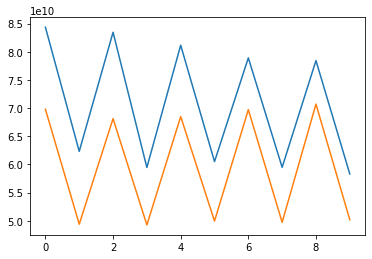

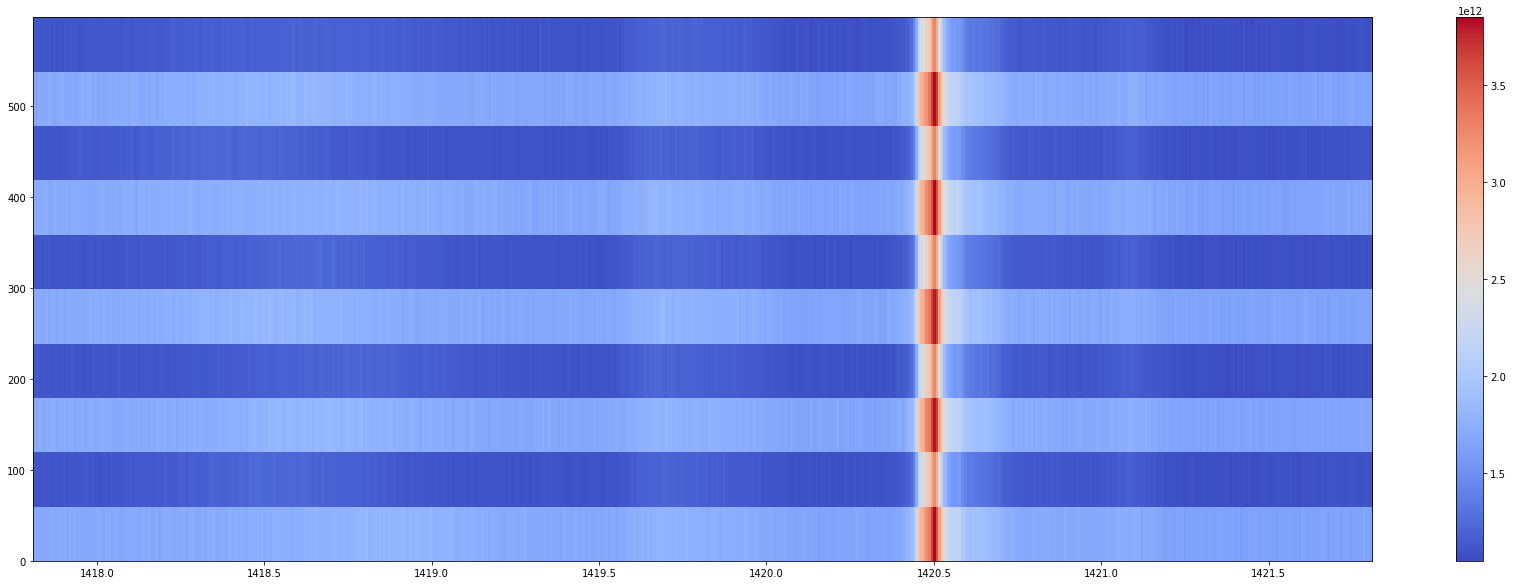

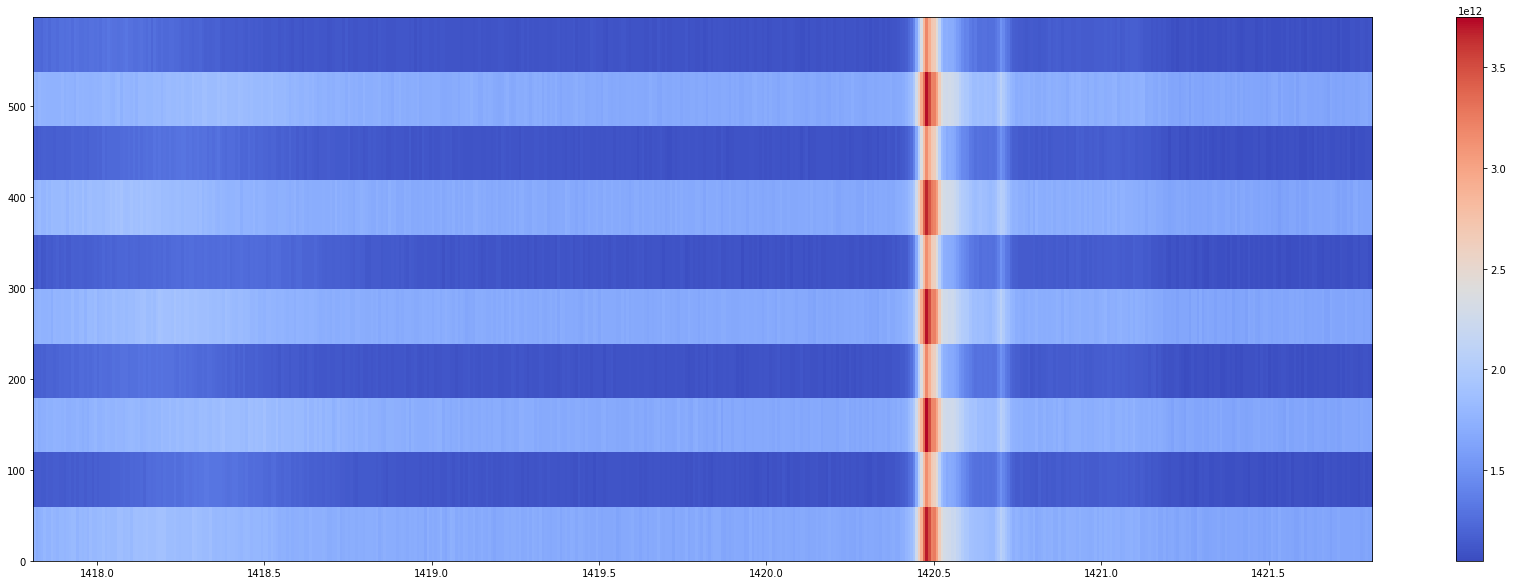

In [87]:
plt.plot(power1_on[0:10,40])
plt.plot(power1_off[0:10,40])

idx_power1_on_calon  = np.arange(0,595,2)
idx_power1_on_caloff = np.arange(1,596,2)

if power1_on[0,40] > power1_on[1,40]:
    power1_on_calon  = power1_on[np.arange(0,595,2),:]
    power1_on_caloff = power1_on[np.arange(1,596,2),:]
else:
    power1_on_calon  = power1_on[np.arange(1,596,2),:]
    power1_on_caloff = power1_on[np.arange(0,595,2),:]



if power1_off[0,40] > power1_off[1,40]:
    power1_off_calon  = power1_off[np.arange(0,595,2),:]
    power1_off_caloff = power1_off[np.arange(1,596,2),:]
else:
    power1_off_calon  = power1_off[np.arange(1,596,2),:]
    power1_off_caloff = power1_off[np.arange(0,595,2),:]


power1_on_calon.shape, power1_on_caloff.shape 
power1_on_calres = power1_on_calon-power1_on_caloff 
power1_off_calres = power1_off_calon-power1_off_caloff 


#here we need to check if the noise on-off-on-off works well when we split the data
plt.figure(figsize=(30,10))
plt.imshow(power1_on[0:10,((freq > freq_min) & (freq < freq_max))], aspect='auto', origin = 'lower', 
           extent=(freq_min, freq_max,0,power1_on[:,0].size), 
          cmap='coolwarm')
plt.colorbar()

plt.figure(figsize=(30,10))
plt.imshow(power1_off[0:10,((freq > freq_min) & (freq < freq_max))], aspect='auto', origin = 'lower', 
           extent=(freq_min, freq_max,0,power1_on[:,0].size), 
          cmap='coolwarm')
plt.colorbar()


# For each frequency:
T_to_P_freq = Tcal / np.average(power1_on_calres,axis=0)


Ta1_on = power1_on_calon - power1_on_calon
for i, iTal_on in enumerate(Ta1_on):
    
    a   = power1_on_calon[i,:] * T_to_P_freq 
    c   = power1_on_caloff[i,:] * T_to_P_freq
    w1  = c**2/(a**2+c**2)
    w2  = a**2/(a**2+c**2)

    Ta1_on[i,:]  =  w1 * (power1_on_calon[i,:] * T_to_P_freq - Tcal) + w2 * (power1_on_caloff[i,:] * T_to_P_freq)
    
    
Ta1_off = power1_off_calon - power1_off_calon
for i, iTal_off in enumerate(Ta1_off):
    
    a   = power1_off_calon[i,:] * T_to_P_freq 
    c   = power1_off_caloff[i,:] * T_to_P_freq
    
    w1  = c**2/(a**2+c**2)
    w2  = a**2/(a**2+c**2)

    Ta1_off[i,:]  =  w1 * (power1_off_calon[i,:] * T_to_P_freq - Tcal) + w2 * (power1_off_caloff[i,:] * T_to_P_freq)


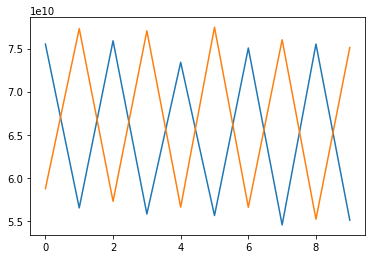

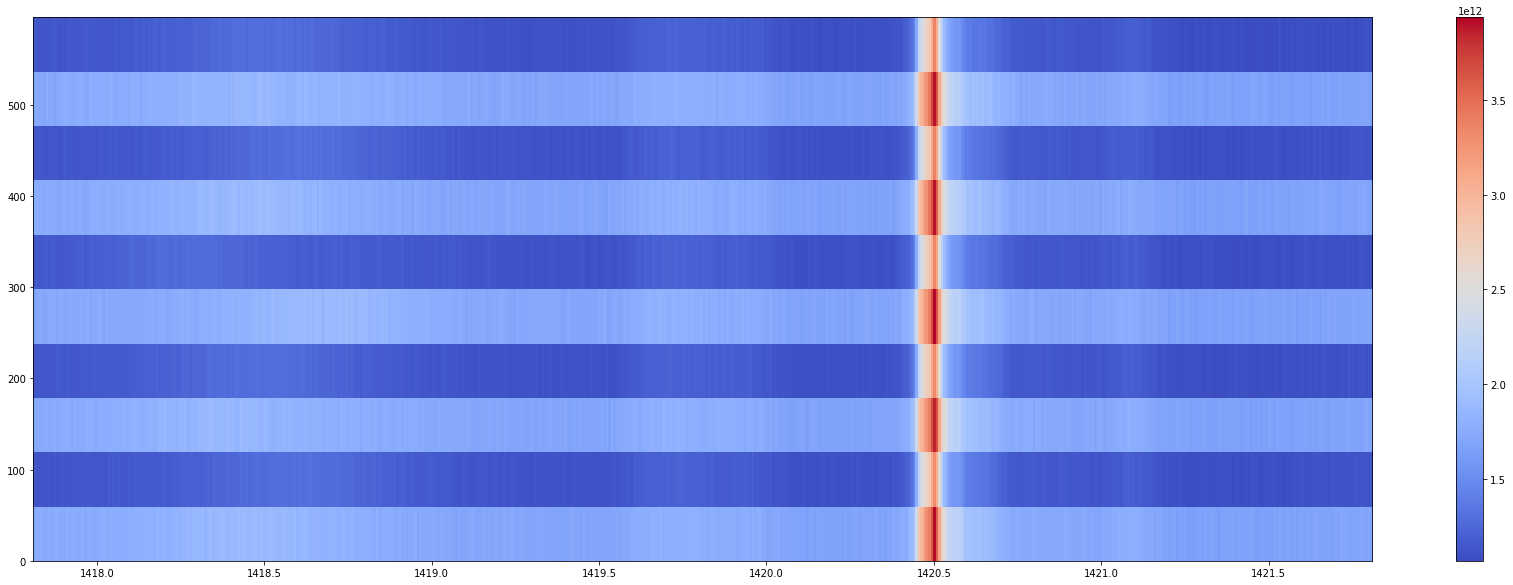

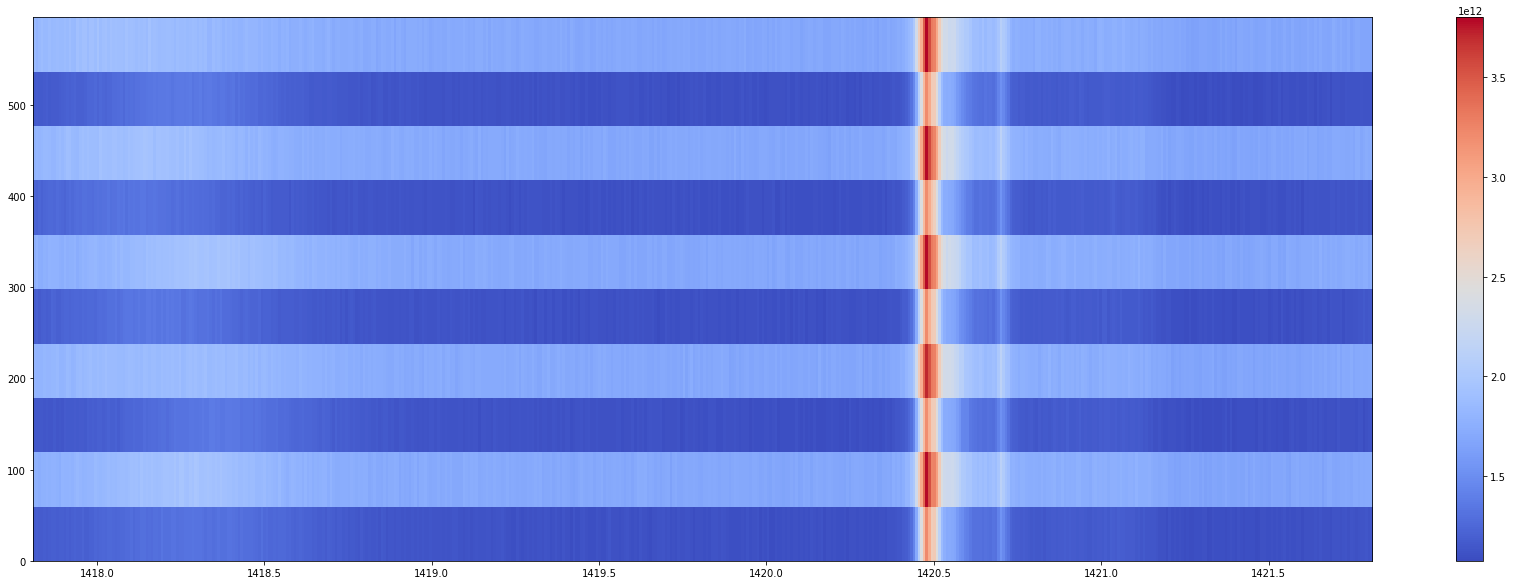

In [88]:
plt.plot(power2_on[0:10,40])
plt.plot(power2_off[0:10,40])

idx_power2_on_calon  = np.arange(0,595,2)
idx_power2_on_caloff = np.arange(1,596,2)

if power2_on[0,40] > power2_on[1,40]:
    power2_on_calon  = power2_on[np.arange(0,595,2),:]
    power2_on_caloff = power2_on[np.arange(1,596,2),:]
else:
    power2_on_calon  = power2_on[np.arange(1,596,2),:]
    power2_on_caloff = power2_on[np.arange(0,595,2),:]



if power2_off[0,40] > power2_off[1,40]:
    power2_off_calon  = power2_off[np.arange(0,595,2),:]
    power2_off_caloff = power2_off[np.arange(1,596,2),:]
else:
    power2_off_calon  = power2_off[np.arange(1,596,2),:]
    power2_off_caloff = power2_off[np.arange(0,595,2),:]


power2_on_calon.shape, power2_on_caloff.shape 
power2_on_calres = power2_on_calon-power2_on_caloff 
power2_off_calres = power2_off_calon-power2_off_caloff 


#here we need to check if the noise on-off-on-off works well when we split the data
plt.figure(figsize=(30,10))
plt.imshow(power2_on[0:10,((freq > freq_min) & (freq < freq_max))], aspect='auto', origin = 'lower', 
           extent=(freq_min, freq_max,0,power2_on[:,0].size), 
          cmap='coolwarm')
plt.colorbar()

plt.figure(figsize=(30,10))
plt.imshow(power2_off[0:10,((freq > freq_min) & (freq < freq_max))], aspect='auto', origin = 'lower', 
           extent=(freq_min, freq_max,0,power2_on[:,0].size), 
          cmap='coolwarm')
plt.colorbar()


# For each frequency:
T_to_P_freq = Tcal / np.average(power2_on_calres,axis=0)


Ta2_on = power2_on_calon - power2_on_calon
for i, iTal_on in enumerate(Ta2_on):
    
    a   = power2_on_calon[i,:] * T_to_P_freq 
    c   = power2_on_caloff[i,:] * T_to_P_freq
    w1  = c**2/(a**2+c**2)
    w2  = a**2/(a**2+c**2)

    Ta2_on[i,:]  =  w1 * (power2_on_calon[i,:] * T_to_P_freq - Tcal) + w2 * (power2_on_caloff[i,:] * T_to_P_freq)
    
    
Ta2_off = power2_off_calon - power2_off_calon
for i, iTal_off in enumerate(Ta2_off):
    
    a   = power2_off_calon[i,:] * T_to_P_freq 
    c   = power2_off_caloff[i,:] * T_to_P_freq
    
    w1  = c**2/(a**2+c**2)
    w2  = a**2/(a**2+c**2)

    Ta2_off[i,:]  =  w1 * (power2_off_calon[i,:] * T_to_P_freq - Tcal) + w2 * (power2_off_caloff[i,:] * T_to_P_freq)


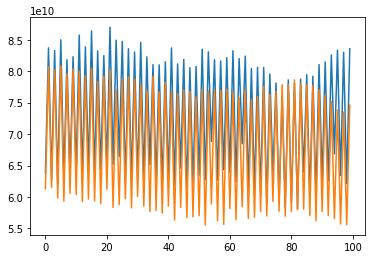

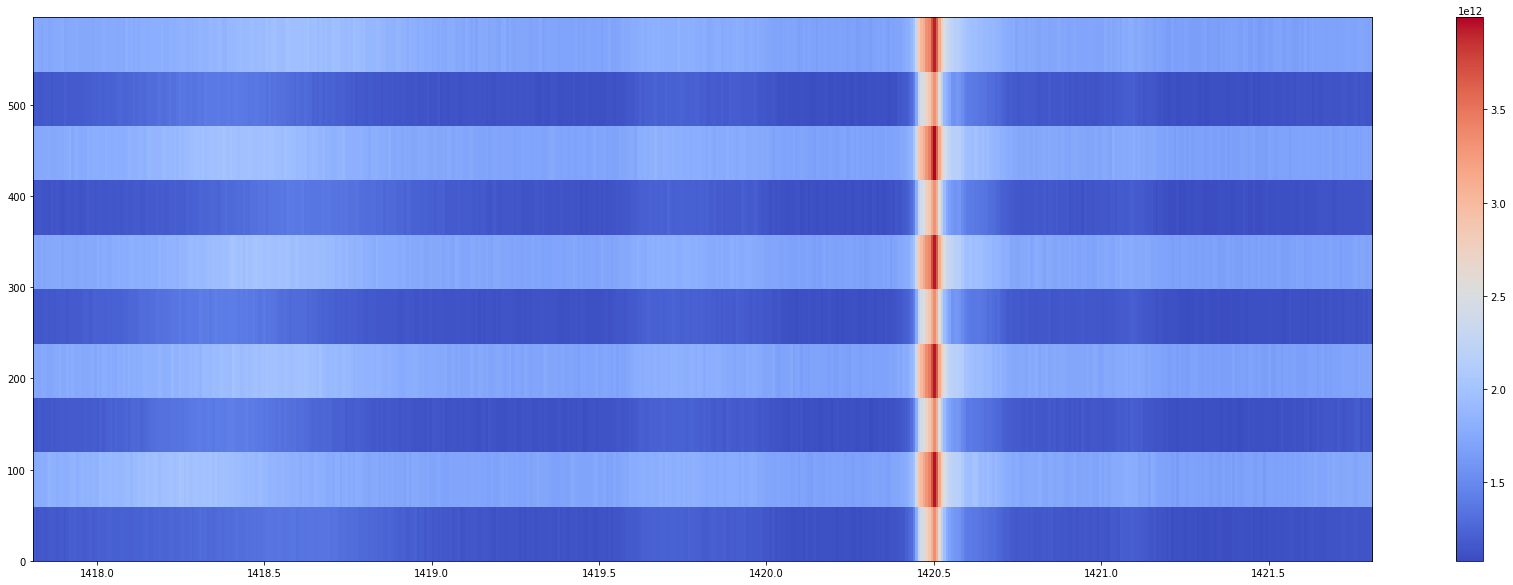

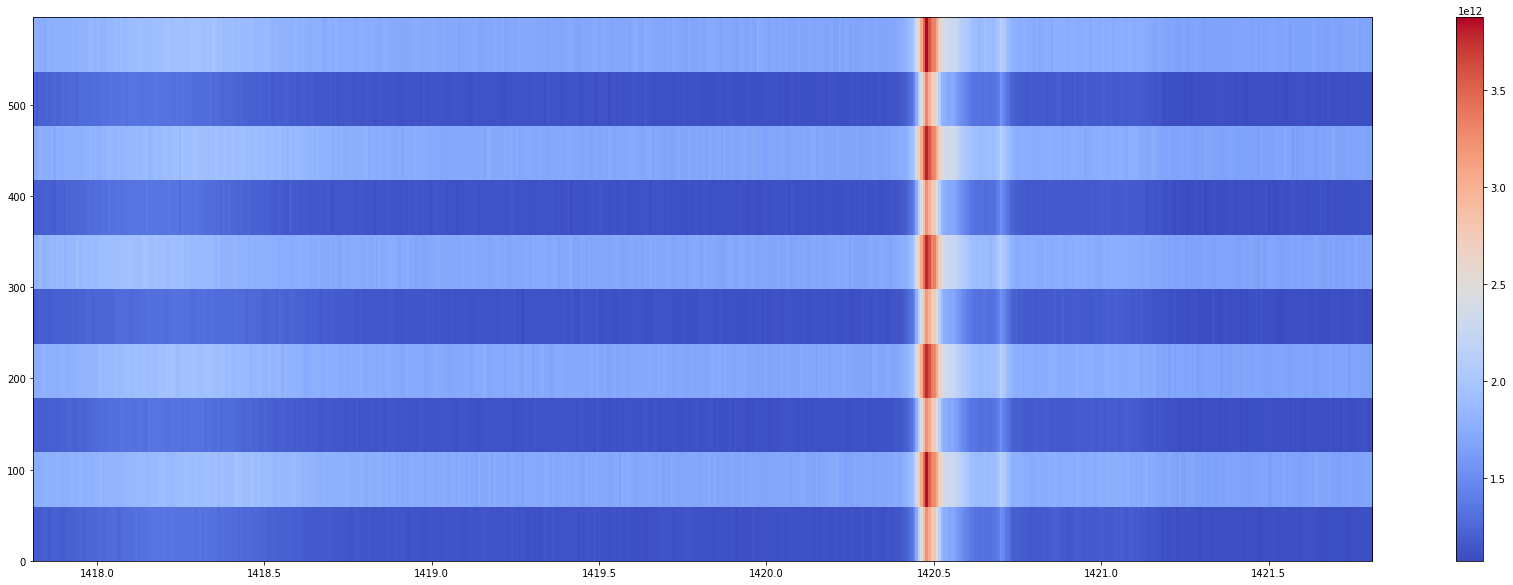

In [89]:
plt.plot(power3_on[0:100,40])
plt.plot(power3_off[0:100,40])

idx_power3_on_calon  = np.arange(0,595,2)
idx_power3_on_caloff = np.arange(1,596,2)

if power3_on[0,40] > power3_on[1,40]:
    power3_on_calon  = power3_on[np.arange(0,595,2),:]
    power3_on_caloff = power3_on[np.arange(1,596,2),:]
else:
    power3_on_calon  = power3_on[np.arange(1,596,2),:]
    power3_on_caloff = power3_on[np.arange(0,595,2),:]



if power3_off[0,40] > power3_off[1,40]:
    power3_off_calon  = power3_off[np.arange(0,595,2),:]
    power3_off_caloff = power3_off[np.arange(1,596,2),:]
else:
    power3_off_calon  = power3_off[np.arange(1,596,2),:]
    power3_off_caloff = power3_off[np.arange(0,595,2),:]


power3_on_calon.shape, power3_on_caloff.shape 
power3_on_calres = power3_on_calon-power3_on_caloff 
power3_off_calres = power3_off_calon-power3_off_caloff 


#here we need to check if the noise on-off-on-off works well when we split the data
plt.figure(figsize=(30,10))
plt.imshow(power3_on[0:10,((freq > freq_min) & (freq < freq_max))], aspect='auto', origin = 'lower', 
           extent=(freq_min, freq_max,0,power3_on[:,0].size), 
          cmap='coolwarm')
plt.colorbar()

plt.figure(figsize=(30,10))
plt.imshow(power3_off[0:10,((freq > freq_min) & (freq < freq_max))], aspect='auto', origin = 'lower', 
           extent=(freq_min, freq_max,0,power3_on[:,0].size), 
          cmap='coolwarm')
plt.colorbar()


# For each frequency:
T_to_P_freq = Tcal / np.average(power3_on_calres,axis=0)


Ta3_on = power3_on_calon - power3_on_calon
for i, iTal_on in enumerate(Ta3_on):
    
    a   = power3_on_calon[i,:] * T_to_P_freq 
    c   = power3_on_caloff[i,:] * T_to_P_freq
    w1  = c**2/(a**2+c**2)
    w2  = a**2/(a**2+c**2)

    Ta3_on[i,:]  =  w1 * (power3_on_calon[i,:] * T_to_P_freq - Tcal) + w2 * (power3_on_caloff[i,:] * T_to_P_freq)
    
    
Ta3_off = power3_off_calon - power3_off_calon
for i, iTal_off in enumerate(Ta3_off):
    
    a   = power3_off_calon[i,:] * T_to_P_freq 
    c   = power3_off_caloff[i,:] * T_to_P_freq
    
    w1  = c**2/(a**2+c**2)
    w2  = a**2/(a**2+c**2)

    Ta3_off[i,:]  =  w1 * (power3_off_calon[i,:] * T_to_P_freq - Tcal) + w2 * (power3_off_caloff[i,:] * T_to_P_freq)


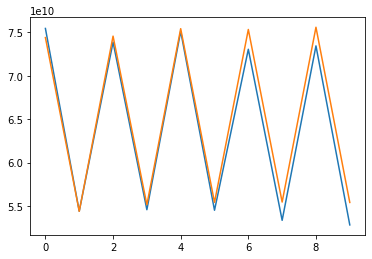

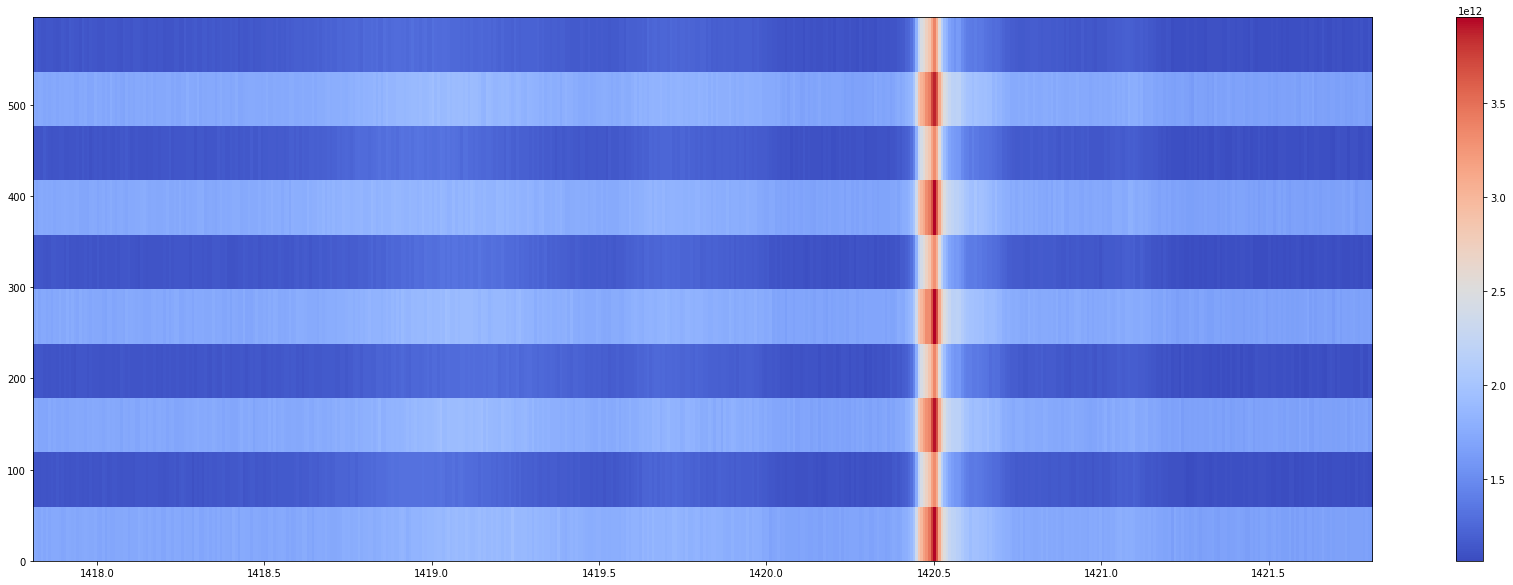

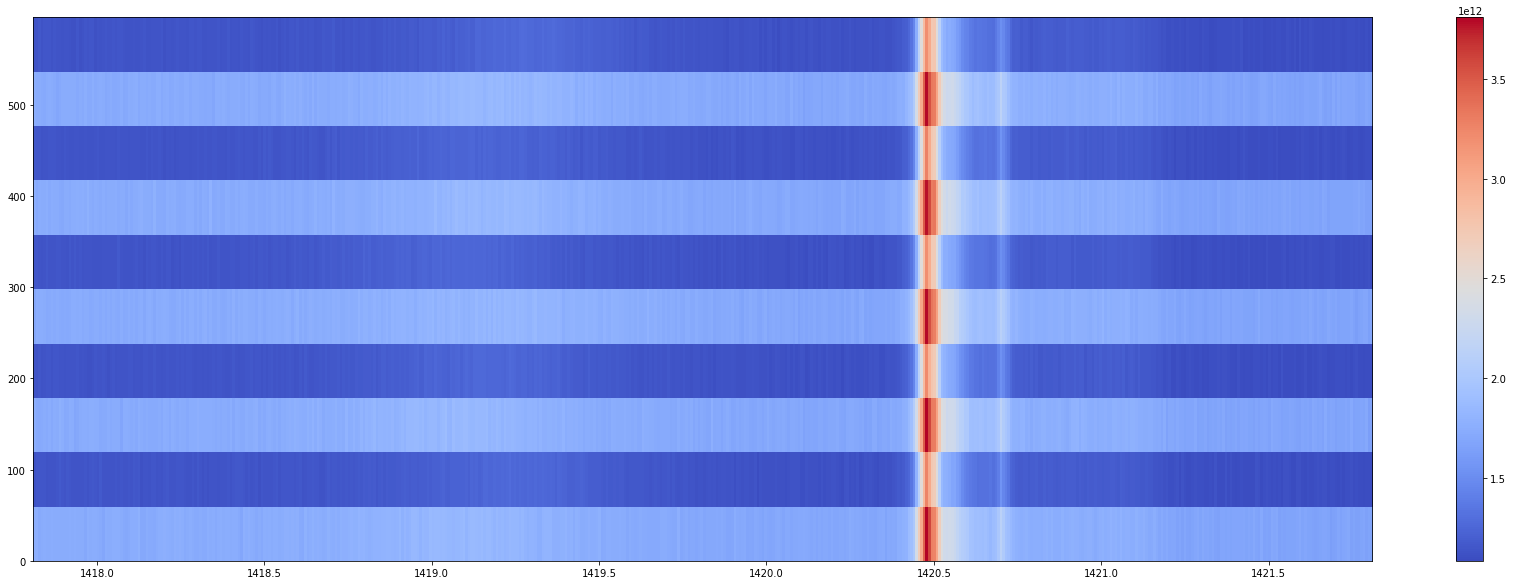

In [90]:
plt.plot(power4_on[0:10,40])
plt.plot(power4_off[0:10,40])

idx_power4_on_calon  = np.arange(0,595,2)
idx_power4_on_caloff = np.arange(1,596,2)

if power4_on[0,40] > power4_on[1,40]:
    power4_on_calon  = power4_on[np.arange(0,595,2),:]
    power4_on_caloff = power4_on[np.arange(1,596,2),:]
else:
    power4_on_calon  = power4_on[np.arange(1,596,2),:]
    power4_on_caloff = power4_on[np.arange(0,595,2),:]



if power4_off[0,40] > power4_off[1,40]:
    power4_off_calon  = power4_off[np.arange(0,595,2),:]
    power4_off_caloff = power4_off[np.arange(1,596,2),:]
else:
    power4_off_calon  = power4_off[np.arange(1,596,2),:]
    power4_off_caloff = power4_off[np.arange(0,595,2),:]


power4_on_calon.shape, power4_on_caloff.shape 
power4_on_calres = power4_on_calon-power4_on_caloff 
power4_off_calres = power4_off_calon-power4_off_caloff 


#here we need to check if the noise on-off-on-off works well when we split the data
plt.figure(figsize=(30,10))
plt.imshow(power4_on[0:10,((freq > freq_min) & (freq < freq_max))], aspect='auto', origin = 'lower', 
           extent=(freq_min, freq_max,0,power4_on[:,0].size), 
          cmap='coolwarm')
plt.colorbar()

plt.figure(figsize=(30,10))
plt.imshow(power4_off[0:10,((freq > freq_min) & (freq < freq_max))], aspect='auto', origin = 'lower', 
           extent=(freq_min, freq_max,0,power4_on[:,0].size), 
          cmap='coolwarm')
plt.colorbar()


# For each frequency:
T_to_P_freq = Tcal / np.average(power4_on_calres,axis=0)


Ta4_on = power4_on_calon - power4_on_calon
for i, iTal_on in enumerate(Ta4_on):
    
    a   = power4_on_calon[i,:] * T_to_P_freq 
    c   = power4_on_caloff[i,:] * T_to_P_freq
    w1  = c**2/(a**2+c**2)
    w2  = a**2/(a**2+c**2)

    Ta4_on[i,:]  =  w1 * (power4_on_calon[i,:] * T_to_P_freq - Tcal) + w2 * (power4_on_caloff[i,:] * T_to_P_freq)
    
    
Ta4_off = power4_off_calon - power4_off_calon
for i, iTal_off in enumerate(Ta4_off):
    
    a   = power4_off_calon[i,:] * T_to_P_freq 
    c   = power4_off_caloff[i,:] * T_to_P_freq
    
    w1  = c**2/(a**2+c**2)
    w2  = a**2/(a**2+c**2)

    Ta4_off[i,:]  =  w1 * (power4_off_calon[i,:] * T_to_P_freq - Tcal) + w2 * (power4_off_caloff[i,:] * T_to_P_freq)


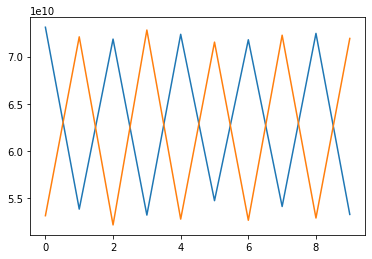

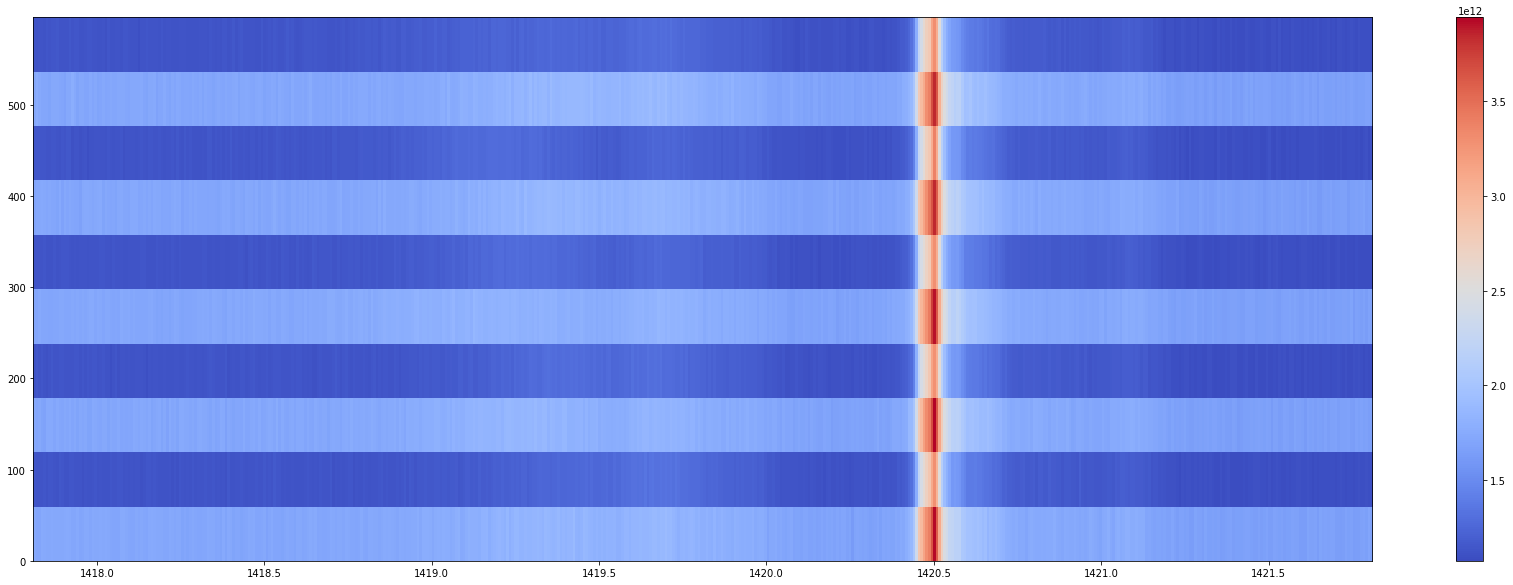

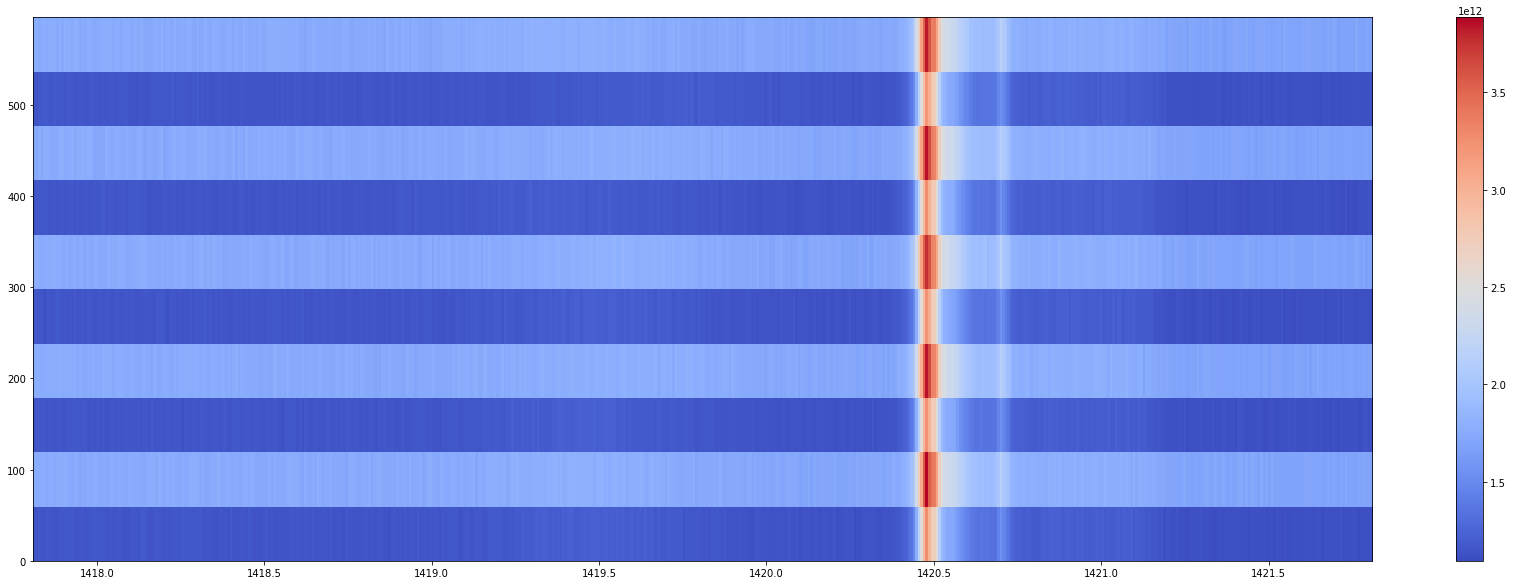

In [91]:
plt.plot(power5_on[0:10,40])
plt.plot(power5_off[0:10,40])

idx_power5_on_calon  = np.arange(0,595,2)
idx_power5_on_caloff = np.arange(1,596,2)

if power5_on[0,40] > power5_on[1,40]:
    power5_on_calon  = power5_on[np.arange(0,595,2),:]
    power5_on_caloff = power5_on[np.arange(1,596,2),:]
else:
    power5_on_calon  = power5_on[np.arange(1,596,2),:]
    power5_on_caloff = power5_on[np.arange(0,595,2),:]



if power5_off[0,40] > power5_off[1,40]:
    power5_off_calon  = power5_off[np.arange(0,595,2),:]
    power5_off_caloff = power5_off[np.arange(1,596,2),:]
else:
    power5_off_calon  = power5_off[np.arange(1,596,2),:]
    power5_off_caloff = power5_off[np.arange(0,595,2),:]


power5_on_calon.shape, power5_on_caloff.shape 
power5_on_calres = power5_on_calon-power5_on_caloff 
power5_off_calres = power5_off_calon-power5_off_caloff 


#here we need to check if the noise on-off-on-off works well when we split the data
plt.figure(figsize=(30,10))
plt.imshow(power5_on[0:10,((freq > freq_min) & (freq < freq_max))], aspect='auto', origin = 'lower', 
           extent=(freq_min, freq_max,0,power5_on[:,0].size), 
          cmap='coolwarm')
plt.colorbar()

plt.figure(figsize=(30,10))
plt.imshow(power5_off[0:10,((freq > freq_min) & (freq < freq_max))], aspect='auto', origin = 'lower', 
           extent=(freq_min, freq_max,0,power5_on[:,0].size), 
          cmap='coolwarm')
plt.colorbar()


# For each frequency:
T_to_P_freq = Tcal / np.average(power5_on_calres,axis=0)


Ta5_on = power5_on_calon - power5_on_calon
for i, iTal_on in enumerate(Ta5_on):
    
    a   = power5_on_calon[i,:] * T_to_P_freq 
    c   = power5_on_caloff[i,:] * T_to_P_freq
    w1  = c**2/(a**2+c**2)
    w2  = a**2/(a**2+c**2)

    Ta5_on[i,:]  =  w1 * (power5_on_calon[i,:] * T_to_P_freq - Tcal) + w2 * (power5_on_caloff[i,:] * T_to_P_freq)
    
    
Ta5_off = power5_off_calon - power5_off_calon
for i, iTal_off in enumerate(Ta5_off):
    
    a   = power5_off_calon[i,:] * T_to_P_freq 
    c   = power5_off_caloff[i,:] * T_to_P_freq
    
    w1  = c**2/(a**2+c**2)
    w2  = a**2/(a**2+c**2)

    Ta5_off[i,:]  =  w1 * (power5_off_calon[i,:] * T_to_P_freq - Tcal) + w2 * (power5_off_caloff[i,:] * T_to_P_freq)


In [92]:
Ta_on = np.vstack((Ta1_on,Ta2_on,Ta3_on,Ta4_on,Ta5_on))
Ta_off = np.vstack((Ta1_off,Ta2_off,Ta3_off,Ta4_off,Ta5_off))


In [58]:

Ta_on = np.vstack((Ta2_on,Ta3_on))
Ta_off = np.vstack((Ta2_off,Ta3_off))

In [93]:
Ta_on.shape, Ta_off.shape

((1490, 65536), (1490, 65536))

In [94]:
np.average(Ta_on, axis=0).shape

(65536,)

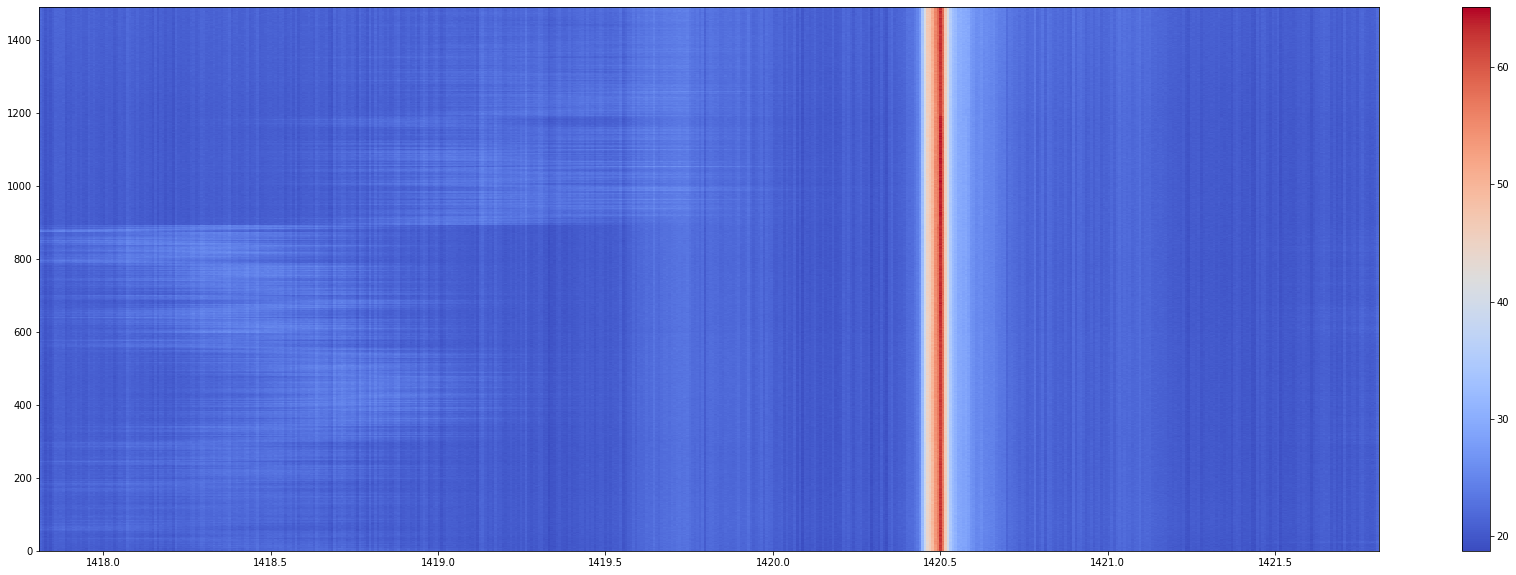

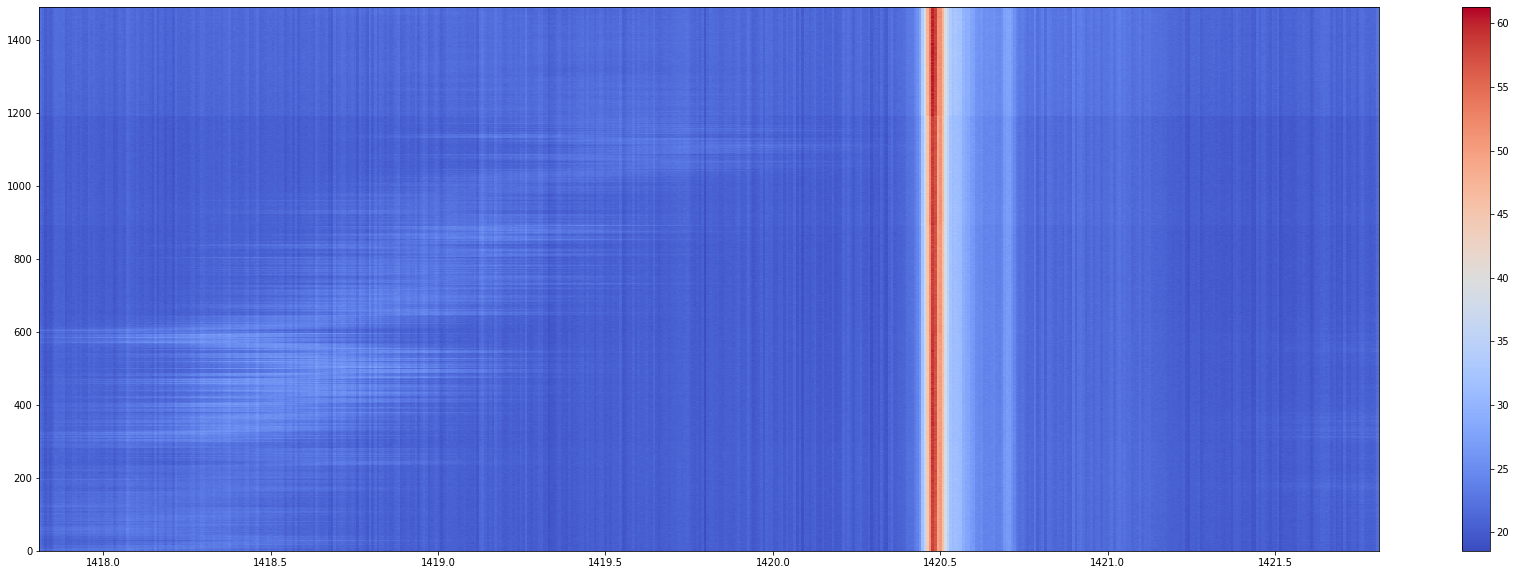

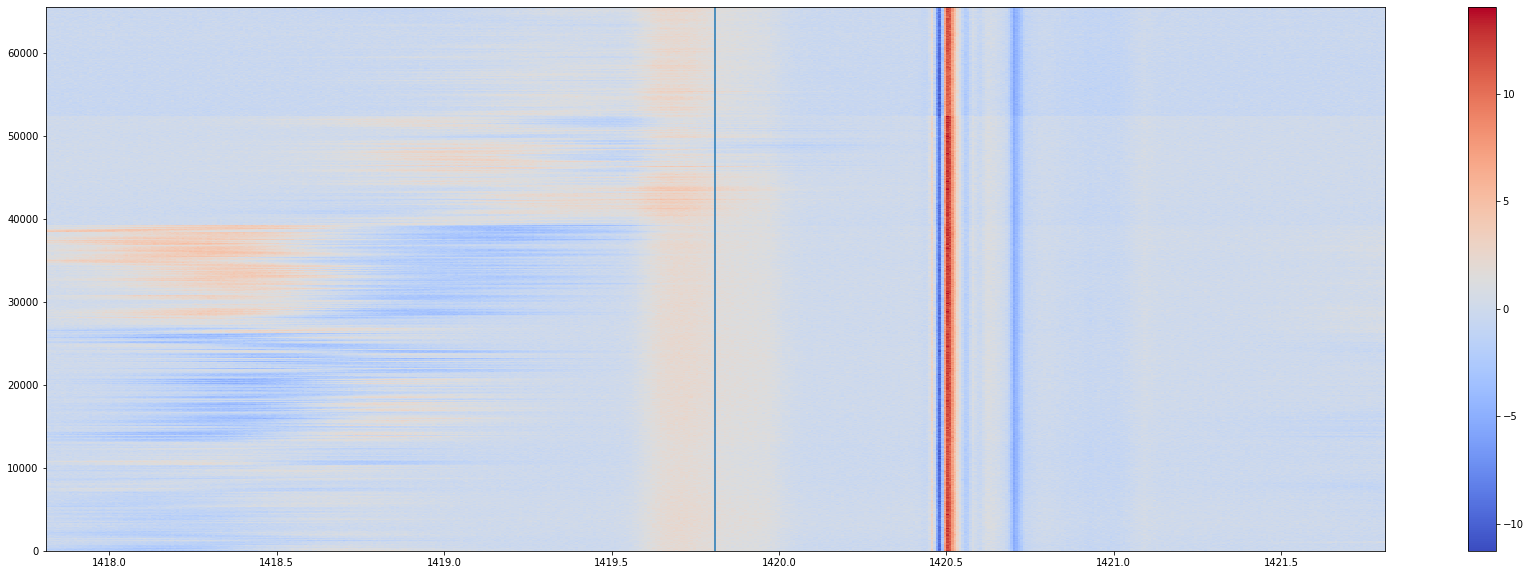

In [95]:
plt.figure(figsize=(30,10))
plt.imshow(Ta_on[:,((freq > freq_min) & (freq < freq_max))], aspect='auto', origin = 'lower', 
           extent=(freq_min, freq_max,0,Ta_on[:,0].size), 
          cmap='coolwarm')
plt.colorbar()

plt.figure(figsize=(30,10))
plt.imshow(Ta_off[:,((freq > freq_min) & (freq < freq_max))], aspect='auto', origin = 'lower', 
           extent=(freq_min, freq_max,0,Ta_off[:,0].size), 
          cmap='coolwarm')
plt.colorbar()

Ta_target = Ta_on - Ta_off

plt.figure(figsize=(30,10))
plt.imshow(Ta_target[:,((freq > freq_min) & (freq < freq_max))], aspect='auto', origin = 'lower', 
           extent=(freq_min, freq_max,0,Ta_target[:,0].size), 
          cmap='coolwarm')
plt.plot([freq_line, freq_line], [0,Ta_target[:,0].size])
plt.colorbar()

In [71]:
len(Ta_on[:,0])

1490

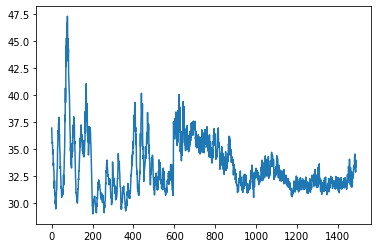

In [96]:
plt.plot(Ta_on[:,100])

(1417.8094310389636, 1421.8094310389636)

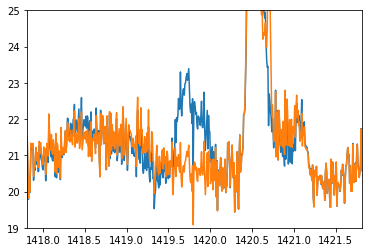

In [97]:
plt.plot(freq, np.median(Ta_on, axis=0))
plt.plot(freq, np.median(Ta_off, axis=0))

plt.plot([freq_line, freq_line], [0,1])
plt.ylim(19,25)
plt.xlim(freq_min,freq_max)


(1417.8094310389636, 1421.8094310389636)

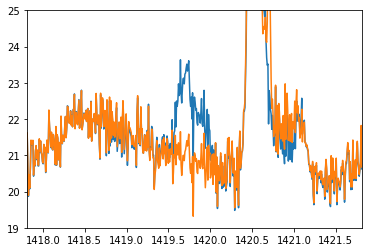

In [98]:
plt.plot(freq, np.average(Ta_on, axis=0))
plt.plot(freq, np.average(Ta_off, axis=0))

plt.plot([freq_line, freq_line], [0,1])
plt.ylim(19,25)
plt.xlim(freq_min,freq_max)


(1417.8094310389636, 1421.8094310389636)

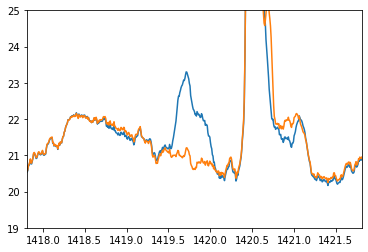

In [103]:
plt.plot(freq, smooth(np.average(Ta_on, axis=0),10))
plt.plot(freq, smooth(np.average(Ta_off, axis=0),10))

plt.plot([freq_line, freq_line], [0,1])
plt.ylim(19,25)
plt.xlim(freq_min,freq_max)


(1417.8094310389636, 1421.8094310389636)

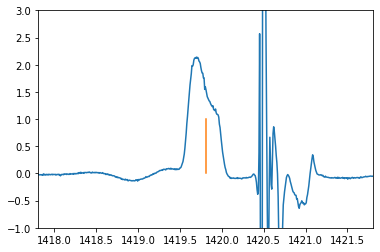

In [100]:
plt.plot(freq, np.average(Ta_on, axis=0) - np.average(Ta_off, axis=0))
plt.plot([freq_line, freq_line], [0,1])
plt.ylim(-1,3)
plt.xlim(freq_min,freq_max)

(1417.8094310389636, 1421.8094310389636)

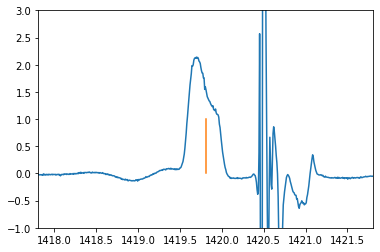

In [104]:
plt.plot(freq, smooth(np.average(Ta_on, axis=0) - np.average(Ta_off, axis=0), 1))
plt.plot([freq_line, freq_line], [0,1])
plt.ylim(-1,3)
plt.xlim(freq_min,freq_max)

In [110]:
velo = 3.e5 * (freq_line - freq) / freq

velo_c = 3.e5 * (1420.405751 - freq) / freq


(-250, 250)

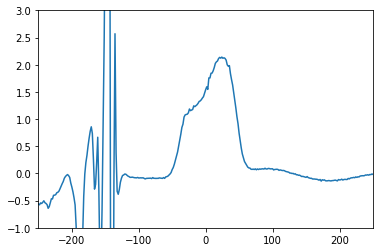

In [112]:
plt.plot(velo, smooth(np.average(Ta_on, axis=0) - np.average(Ta_off, axis=0), 1))
plt.ylim(-1,3)
plt.xlim(-250,250)


(-100, 250)

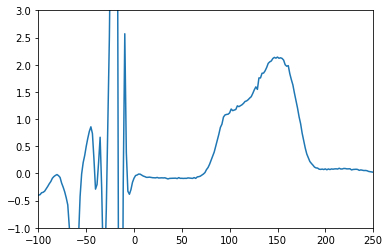

In [115]:

plt.plot(velo_c, smooth(np.average(Ta_on, axis=0) - np.average(Ta_off, axis=0), 1))
plt.ylim(-1,3)
plt.xlim(-100,250)